### Quick Demo of Causal Impact on Rossman Sales Dataset

BY KAY H. BRODERSEN, FABIAN GALLUSSER, JIM KOEHLER,
NICOLAS REMY AND STEVEN L. SCOTT
Google, Inc.

An important problem in econometrics and marketing is to infer the
causal impact that a designed market intervention has exerted on an outcome metric over time. This paper proposes to infer causal impact on the
basis of a diffusion-regression state-space model that predicts the counterfactual market response in a synthetic control that would have occurred had
no intervention taken place. In contrast to classical difference-in-differences
schemes, state-space models make it possible to (i) infer the temporal evolution of attributable impact, (ii) incorporate empirical priors on the parameters in a fully Bayesian treatment, and (iii) flexibly accommodate multiple
sources of variation, including local trends, seasonality and the time-varying
influence of contemporaneous covariates. Using a Markov chain Monte Carlo
algorithm for posterior inference, we illustrate the statistical properties of our
approach on simulated data. We then demonstrate its practical utility by estimating the causal effect of an online advertising campaign on search-related
site visits. We discuss the strengths and limitations of state-space models in
enabling causal attribution in those settings where a randomised experiment
is unavailable. The CausalImpact R package provides an implementation of
our approach.

Google Research Paper:
https://research.google/pubs/pub41854/

Original Google R library:
https://github.com/google/CausalImpact

Python port of Google library:
https://github.com/dafiti/causalimpact

## The main ideas

1. Synthetic Control
    - Compared with the 'blunt instrument' of an average statistic for a control group


2. Bayesian Structural Time Series
    - general
    - flexible (e.g. time varying regression parameters)
    - modular
    - strong structural assumptions allow for causal conclusions
    - MCMC estimation of posterior gives better confidence estimations

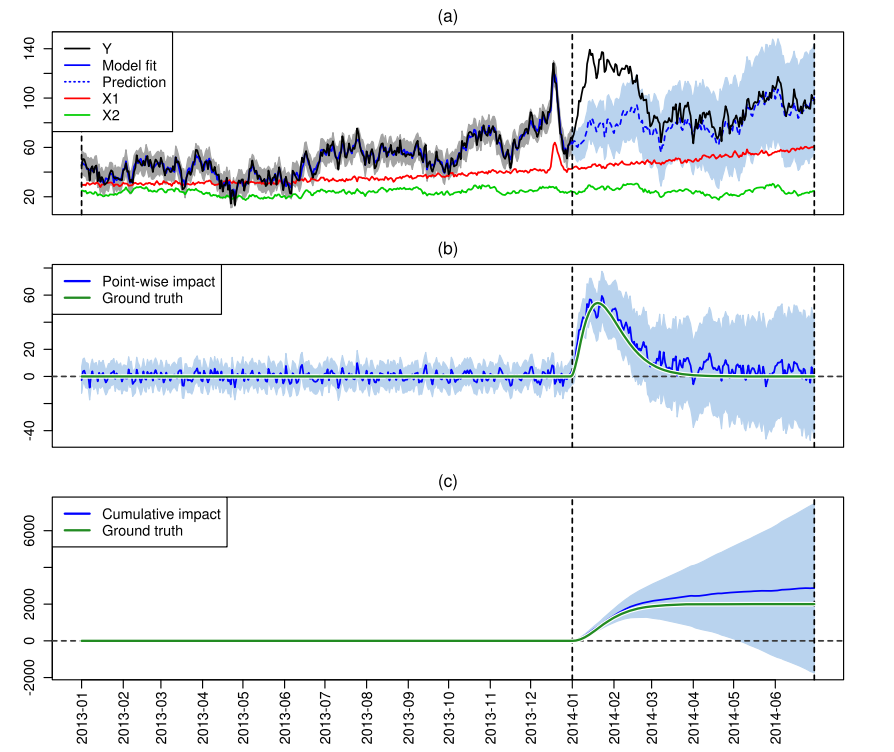




# Bayesian Structural Time-Series


- Local Linear Trend Model
    - like an intercept but time variable
    - unobserved
    - observed - level
    - unobserved - 'level'


- Seasonal component
    - indicator variables


- Contemporaneous Regressors
    - static coefficients

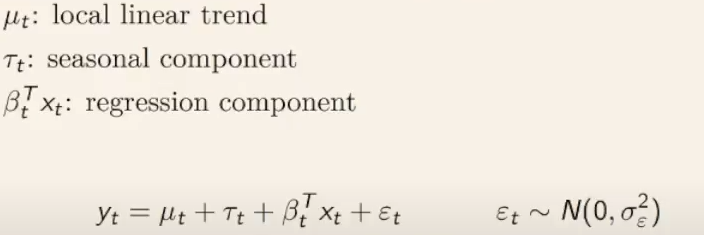

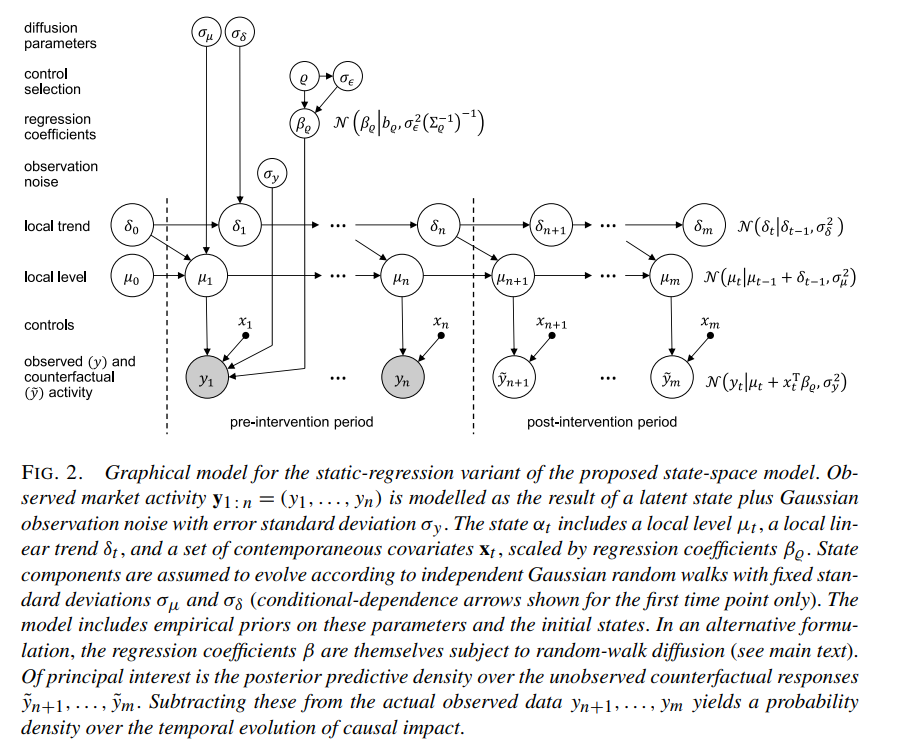

# Some Greek
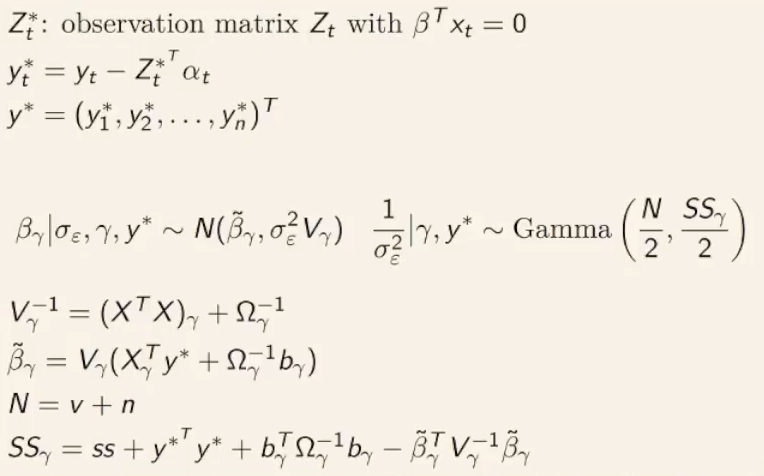

In [ ]:
!pip install pycausalimpact

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import causalimpact

In [ ]:
np.random.seed(seed=42)

## Read in Rossman training dataset

In [ ]:
rossman_train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', parse_dates=['Date']);

rossman_train_df.sample(10)

In [ ]:
rossman_train_df['StoreName'] = 'Store_'+('000'+rossman_train_df.Store.astype(str)).str[-4:]

experimental_store = 603

pre_period = [pd.Timestamp(2014,5,1), pd.Timestamp(2015,4,30)]
post_period = [pd.Timestamp(2015,5,1), pd.Timestamp(2015,7,31)]

rossman_train_df['Intervention'] = np.where(rossman_train_df.Date >= post_period[0], 'Pre Intervention', 'Post Intervention')

## Add some hypothetical results from 'interventions'

In [ ]:
target = rossman_train_df[rossman_train_df.Store == experimental_store].groupby('Date')[['Sales']].mean()

relative_effect = 0.1

noise = np.random.randn(len(target))/20

np.random.rand(len(target))

target['target']        = target.Sales

target['target_plus_5'] = np.where(target.index <= pre_period[1], 
                                      target.Sales, 
                                      target.Sales*(1.05+noise))

target['target_minus_5'] = np.where(target.index <= pre_period[1], 
                                      target.Sales, 
                                      target.Sales*(0.95+noise))

target['target_plus_10'] = np.where(target.index <= pre_period[1], 
                                      target.Sales, 
                                      target.Sales*(1.1+noise))

target['target_minus_10'] = np.where(target.index <= pre_period[1], 
                                      target.Sales, 
                                      target.Sales*(0.9+noise))

### Choose some stores at random as regressors

In [ ]:
n_regressors = 25
regression_stores = sorted(rossman_train_df[rossman_train_df.Store != experimental_store].Store.unique())
idxs = list(np.random.choice(list(range(len(regression_stores))),n_regressors))
regression_stores = [regression_stores[idx] for idx in idxs]

### Pivot data so that Regressors are in columns[](http://)

In [ ]:
pivoted_df = pd.pivot_table(rossman_train_df[rossman_train_df.Store.isin([experimental_store, *regression_stores])], index='Date', values= ['Sales', 'Open', 'Promo', 'SchoolHoliday'], columns = ['StoreName'])

In [ ]:
pivoted_df.columns = [f'{c[0]}_{c[1]}' for c in pivoted_df.columns]

In [ ]:

plt.figure(figsize=(30,5))


pre_filter  = (pivoted_df.index >= pd.Timestamp(2015,4,1)) & (pivoted_df.index <= pre_period[1])
post_filter = (pivoted_df.index >= pre_period[1])
pre_post_filter = (pivoted_df.index >= pd.Timestamp(2015,4,1))

another_store_sales = f'Sales_Store_{regression_stores[0]:04}'


ax = plt.gca()
ax.plot(pivoted_df[pre_post_filter][pivoted_df.Sales_Store_0603 > 0].Sales_Store_0603, ls='--', c='red', label='original sales without intervention')
ax.plot(target[pre_post_filter][target.target_plus_10 > 0].target_plus_10, ls='-', c='red', label='sales plus noisy 10%')
ax.plot(pivoted_df[pre_post_filter][pivoted_df[another_store_sales] > 0][another_store_sales], ls='-', c='blue', label='another store')

ax.legend()

ax.axvline(pre_period[1], c='black', ls='--')

### Difference in Differences Regression

In [ ]:
did_df = rossman_train_df[(rossman_train_df.Store==experimental_store)|(rossman_train_df.Store.isin(regression_stores))].copy()


did_df.Sales        = np.where( (did_df.Date >= pre_period[1])
                                &(did_df.Store==experimental_store), 
                                  did_df.Sales*(1.1+np.random.randn(len(did_df))/20), 
                                  did_df.Sales)

did_df.Sales  = did_df.Sales/did_df.Sales.mean()

did_df.Intervention = np.where((did_df.Date > pre_period[1]) & (did_df.Store==experimental_store), 1, 0)
did_df = did_df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Intervention', 'StoreName']]

import statsmodels.formula.api as smf 
import statsmodels.api as sm  

model = smf.ols(formula = "Sales ~ Open + Promo + StateHoliday + SchoolHoliday + Intervention + StoreName", data = did_df).fit()
print(model.summary())



In [ ]:
did_df = rossman_train_df[(rossman_train_df.Store==experimental_store)|(rossman_train_df.Store.isin(regression_stores))].copy()

did_df.Sales  = did_df.Sales/did_df.Sales.mean()

did_df.Intervention = np.where((did_df.Date > pre_period[1]) & (did_df.Store==experimental_store), 1, 0)
did_df = did_df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Intervention', 'StoreName']]

import statsmodels.formula.api as smf 
import statsmodels.api as sm  

model = smf.ols(formula = "Sales ~ Open + Promo + StateHoliday + SchoolHoliday + Intervention + StoreName", data = did_df).fit()
print(model.summary())



## A-A testing

In [ ]:
low_sd_cols = pivoted_df.columns[pivoted_df.std()<0.1]

In [ ]:
data = pivoted_df[['Sales_Store_0603', *[c for c in pivoted_df.columns if c not in ['Sales_Store_0603', *low_sd_cols]]]].fillna(0)

ci_orig = causalimpact.CausalImpact(data, pre_period, post_period, nseasons=[{'period': 7, 'harmonics': 2}], prior_level_sd=0.01)

ci_orig.plot()

In [ ]:
print(ci_orig.summary())

### Testing for synthetically generated impact

In [ ]:
data = pivoted_df[['Sales_Store_0603', *[c for c in pivoted_df.columns if c not in ['Sales_Store_0603', *low_sd_cols]]]].fillna(0)

data['Sales_Store_0603'] = target['target_plus_5']

ci_plus_5 = causalimpact.CausalImpact(data, pre_period, post_period, nseasons=[{'period': 7, 'harmonics': 2}])

ci_plus_5.plot()

In [ ]:
print(ci_plus_5.summary())

In [ ]:
data = pivoted_df[['Sales_Store_0603', *[c for c in pivoted_df.columns if c not in ['Sales_Store_0603', *low_sd_cols]]]].fillna(0)

data['Sales_Store_0603'] = target['target_minus_10']

ci_minus_10 = causalimpact.CausalImpact(data, pre_period, post_period, nseasons=[{'period': 7, 'harmonics': 2}])

ci_minus_10.plot()

In [ ]:
print(ci_minus_10.summary())